<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/unsupervised_anomaly_pipeline_appl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Standardized Environment Setup

# Uninstall conflicting packages (one-time cleanup)
!pip uninstall -y protobuf tensorflow gym keras torch torchvision torchaudio || true

# Install Core ML & RL Libraries (pinned versions)
!pip install protobuf==3.20.3 tensorflow==2.18.0 stable-baselines3[extra] gymnasium gym-anytrading yfinance xgboost joblib matplotlib pandas numpy scipy scikit-learn imblearn

# Install PyTorch with CUDA 12.4 support
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

# RAPIDS GPU Acceleration (CUDA 12 compatible)
!pip install --upgrade --force-reinstall \
    dask==2024.11.2 \
    rapids-dask-dependency==24.12.0 \
    cudf-cu12==24.12.0 \
    cuml-cu12==24.12.0 \
    pylibraft-cu12==24.12.0 \
    pylibcudf-cu12==24.12.0 \
    numba==0.61.0


Found existing installation: protobuf 5.29.4
Uninstalling protobuf-5.29.4:
  Successfully uninstalled protobuf-5.29.4
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 2.

Looking in indexes: https://download.pytorch.org/whl/cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 61.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━

In [1]:
# Set CUDA Paths (clearly once)
import os
os.environ['CUDA_HOME'] = '/usr/local/cuda-12.4'
os.environ['PATH'] += ':/usr/local/cuda-12.4/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda-12.4/lib64'

# Verify GPU Availability and Library Versions
import torch, tensorflow as tf, cudf, cuml, dask, gymnasium, stable_baselines3
print("\n🖥️ GPU & Library Versions")
print("-------------------------")
print(f"PyTorch Version: {torch.__version__}, GPU: {torch.cuda.is_available()}")
print(f"TensorFlow Version: {tf.__version__}, GPU: {tf.config.list_physical_devices('GPU')}")
print(f"cuDF Version: {cudf.__version__}")
print(f"cuML Version: {cuml.__version__}")
print(f"Dask Version: {dask.__version__}")
print(f"Gymnasium Version: {gymnasium.__version__}")
print(f"Stable Baselines3 Version: {stable_baselines3.__version__}")

# Final GPU Check
!nvidia-smi



🖥️ GPU & Library Versions
-------------------------
PyTorch Version: 2.6.0+cu124, GPU: True
TensorFlow Version: 2.18.0, GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
cuDF Version: 24.12.00
cuML Version: 24.12.00
Dask Version: 2024.11.2
Gymnasium Version: 1.1.1
Stable Baselines3 Version: 2.6.0
Thu Apr  3 02:04:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|  

In [24]:
# UNIFIED UNSUPERVISED TRADING MODULE (PyTorch Autoencoder CPU-safe)

import os
import gc
import cudf
import cuml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cuml.cluster import DBSCAN, KMeans as cuKMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

import yfinance as yf

# PyTorch replacement for Keras
import torch
import torch.nn as nn
import torch.optim as optim

# Load Stock Data
def load_stock_data(ticker="aapl", period="720d", interval="1h"):
    print(f"Downloading {ticker} stock data...")
    df = yf.download(ticker, period=period, interval=interval)
    if not df.empty:
        print("Downloaded successfully.")
        df.reset_index(inplace=True)
        return df
    else:
        raise ValueError("Failed to download data.")

df = load_stock_data("aapl")

# Fix & Clean Index
def fix_dataframe_index(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df.loc[:, ~df.columns.duplicated()]

# Compute Technical Indicators
def compute_technical_indicators(df):
    df = df.copy()
    df = fix_dataframe_index(df)

    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / (loss + 1e-6)
    df['RSI'] = 100 - (100 / (1 + rs))

    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26

    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    df.dropna(inplace=True)
    return df

# Isolation Forest
def run_isolation_forest(df):
    df = df.dropna(subset=['RSI', 'MACD', 'OBV']).copy()
    X = df[['RSI', 'MACD', 'OBV']]
    clf = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
    df['anomaly_iforest'] = clf.fit_predict(X)
    return df

# One-Class SVM
def run_one_class_svm(df):
    df = df.dropna(subset=['RSI', 'MACD', 'OBV']).copy()
    X = StandardScaler().fit_transform(df[['RSI', 'MACD', 'OBV']])
    svm = OneClassSVM(nu=0.05, kernel='rbf', gamma=0.1)
    df['anomaly_ocsvm'] = svm.fit_predict(X)
    return df

# Dimensionality Reduction
def run_dimensionality_reduction(df, method='PCA'):
    df = df.dropna(subset=['RSI', 'MACD', 'OBV']).copy()
    X = StandardScaler().fit_transform(df[['RSI', 'MACD', 'OBV']])

    if method == 'PCA':
        reducer = PCA(n_components=2)
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, perplexity=30, max_iter=300)  # fixed warning
    elif method == 'UMAP':
        reducer = umap.UMAP(n_components=2)
    else:
        raise ValueError("Invalid method")

    reduced = reducer.fit_transform(X)
    df['dim1'], df['dim2'] = reduced[:, 0], reduced[:, 1]
    return df


# PyTorch Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

def run_autoencoder(df):
    df = df.dropna(subset=['RSI', 'MACD', 'OBV']).copy()
    X = StandardScaler().fit_transform(df[['RSI', 'MACD', 'OBV']])
    X_tensor = torch.tensor(X, dtype=torch.float32)

    model = Autoencoder(X_tensor.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(30):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, X_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        reconstructions = model(X_tensor)
        mse = torch.mean((X_tensor - reconstructions) ** 2, dim=1).numpy()
        df['anomaly_autoencoder'] = (mse > np.percentile(mse, 95)).astype(int)

    return df

# Execute Full Pipeline
df = compute_technical_indicators(df)
df = run_isolation_forest(df)
df = run_one_class_svm(df)
df = run_dimensionality_reduction(df, method='t-SNE')
df = run_autoencoder(df)


[*********************100%***********************]  1 of 1 completed


Downloaded successfully.


In [25]:
print(df.columns)


Index(['Datetime', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'MACD',
       'OBV', 'anomaly_iforest', 'anomaly_ocsvm', 'dim1', 'dim2',
       'anomaly_autoencoder'],
      dtype='object', name='Price')


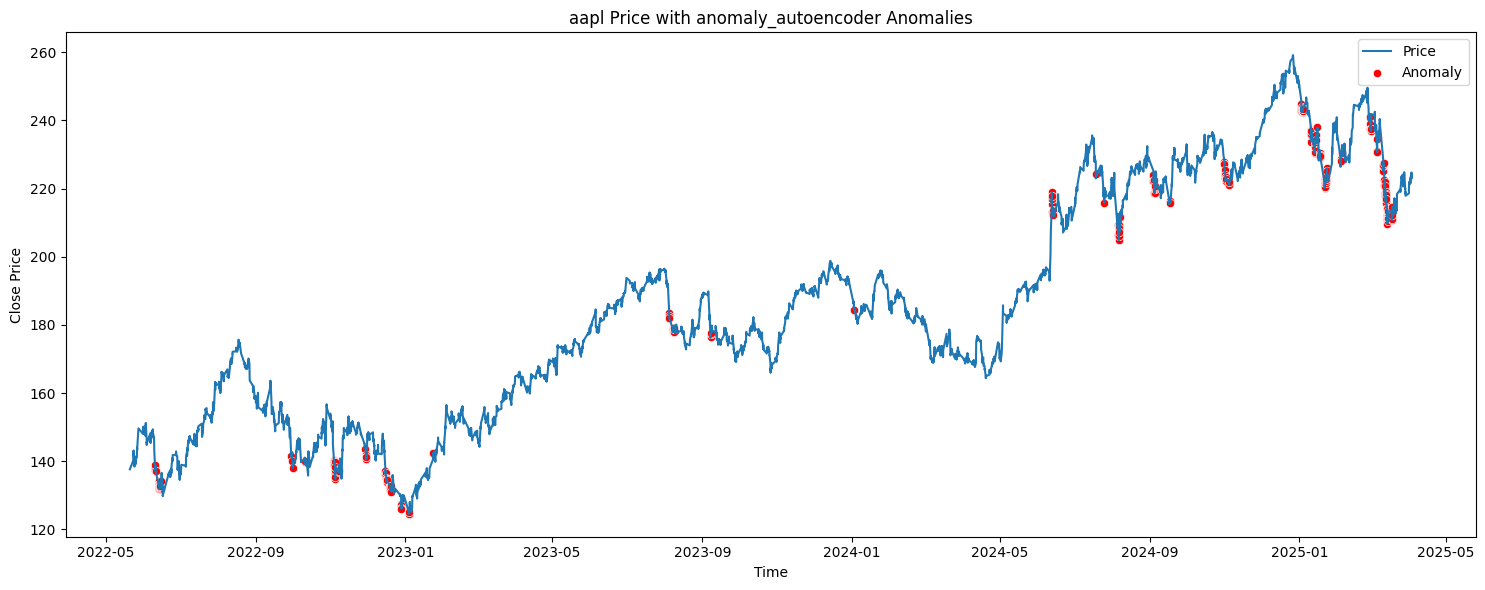

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_anomalies(df, method='anomaly_autoencoder'):
    time_col = 'Datetime'  # Confirmed from your df.index

    plt.figure(figsize=(15, 6))
    sns.lineplot(x=time_col, y='Close', data=df, label='Price')
    sns.scatterplot(
        data=df[df[method] == 1],
        x=time_col, y='Close',
        color='red', label='Anomaly'
    )
    plt.title(f'aapl Price with {method} Anomalies')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_anomalies(df, method='anomaly_autoencoder')


In [27]:
df['signal'] = 0
df.loc[df['anomaly_autoencoder'] == 1, 'signal'] = -1  # Potential sell
df.loc[(df['RSI'] < 30) & (df['anomaly_autoencoder'] == 0), 'signal'] = 1  # Potential buy


In [28]:
df.to_csv('aapl_anomaly_features.csv', index=False)
print(" Data saved.")


 Data saved.


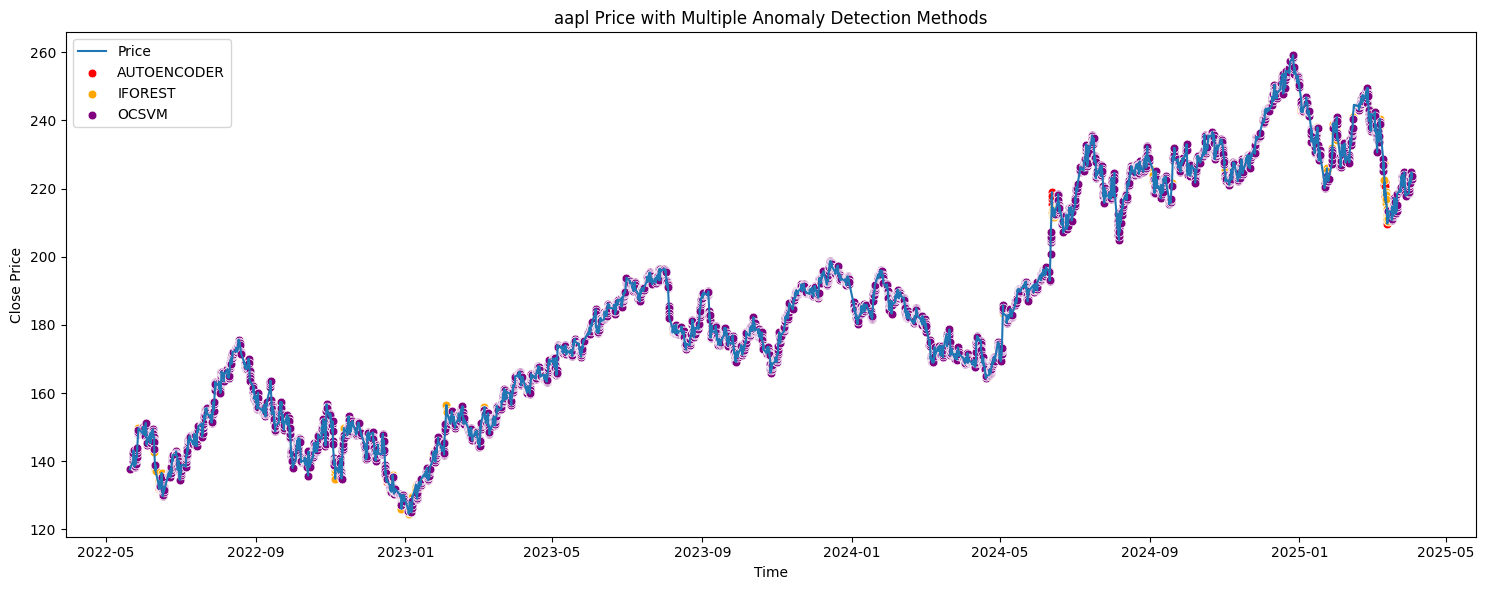

In [29]:
def compare_anomaly_methods(df):
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df, x='Datetime', y='Close', label='Price')

    for method, color in zip(['anomaly_autoencoder', 'anomaly_iforest', 'anomaly_ocsvm'], ['red', 'orange', 'purple']):
        sns.scatterplot(
            data=df[df[method] == 1],
            x='Datetime', y='Close',
            label=method.replace("anomaly_", "").upper(),
            s=40, marker='o', color=color
        )

    plt.title('aapl Price with Multiple Anomaly Detection Methods')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

compare_anomaly_methods(df)


In [30]:
anomaly_dates = df[df['anomaly_autoencoder'] == 1][['Datetime', 'Close']]
display(anomaly_dates.head())


Price,Datetime,Close
105,2022-06-10 13:30:00+00:00,137.490005
106,2022-06-10 14:30:00+00:00,137.399994
107,2022-06-10 15:30:00+00:00,137.975006
108,2022-06-10 16:30:00+00:00,138.089996
109,2022-06-10 17:30:00+00:00,137.960007


In [31]:
df[df['anomaly_autoencoder'] == 1][['Datetime', 'Close']].to_csv('autoencoder_anomalies.csv', index=False)


In [32]:
anomaly_counts = {
    "Autoencoder": df['anomaly_autoencoder'].sum(),
    "IForest": df['anomaly_iforest'].sum(),
    "OCSVM": df['anomaly_ocsvm'].sum()
}
print(" Anomaly Counts:\n", anomaly_counts)


 Anomaly Counts:
 {'Autoencoder': np.int64(251), 'IForest': np.int64(4901), 'OCSVM': np.int64(4501)}


In [33]:
df['overlap_auto_iforest'] = ((df['anomaly_autoencoder'] == 1) & (df['anomaly_iforest'] == 1)).astype(int)
df['overlap_auto_ocsvm'] = ((df['anomaly_autoencoder'] == 1) & (df['anomaly_ocsvm'] == 1)).astype(int)

print("Overlap (Autoencoder & IForest):", df['overlap_auto_iforest'].sum())
print("Overlap (Autoencoder & OCSVM):", df['overlap_auto_ocsvm'].sum())


Overlap (Autoencoder & IForest): 220
Overlap (Autoencoder & OCSVM): 138


In [34]:
with open('anomaly_counts.json', 'w') as f:
    json.dump({
        'Autoencoder': int(df['anomaly_autoencoder'].sum()),
        'IForest': int(df['anomaly_iforest'].sum()),
        'OCSVM': int(df['anomaly_ocsvm'].sum())
    }, f, indent=2)
